In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.backends.mps as mps 
import copy
import time
import matplotlib.pyplot as plt

# Configuration

In [137]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Running on device %s" % device)

Running on device mps


In [138]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Datasets

In [139]:
batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


# Simple CNN model

In [140]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Evaluate

In [141]:
def evaluate_model(model, dataloader):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total  # Accuracy in %

In [142]:
def compute_communication_efficiency(final_accuracy, sync_steps):
    return final_accuracy / sync_steps if sync_steps > 0 else final_accuracy


# AGC Function

In [143]:
def apply_agc_quantization(model, num_bits=8):
    scale = 2 ** num_bits - 1
    for param in model.parameters():
        if param.grad is not None:
            grad = param.grad
            min_val, max_val = grad.min(), grad.max()
            grad = (grad - min_val) / (max_val - min_val) * scale
            grad = torch.round(grad) / scale * (max_val - min_val) + min_val
            param.grad = grad

# Training function

In [144]:
def train_baseline(model, epochs=10):
    model = copy.deepcopy(model).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    accuracy_history = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(trainloader)
        loss_history.append(avg_loss)
        accuracy_history.append(evaluate_model(model, testloader))
        print("Epoch %d: Loss = %.4f, Accuracy = %.2f%%" % (epoch + 1, avg_loss, accuracy_history[-1]))
    
    return model, loss_history, accuracy_history

In [145]:
def train_with_agc(model, epochs=10):
    model = copy.deepcopy(model).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    accuracy_history = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            apply_agc_quantization(model)  # Apply AGC using quantization
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(trainloader)
        loss_history.append(avg_loss)
        accuracy_history.append(evaluate_model(model, testloader))
        print("Epoch %d: Loss = %.4f, Accuracy = %.2f%%" % (epoch + 1, avg_loss, accuracy_history[-1]))
    
    return model, loss_history, accuracy_history

In [146]:
def train_with_lusgd(model, K=5, epochs=10):
    model = copy.deepcopy(model).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    accuracy_history = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        local_model = copy.deepcopy(model.state_dict())

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            if (i + 1) % K == 0:
                with torch.no_grad():
                    global_state_dict = model.state_dict()
                    for key in global_state_dict:
                        global_state_dict[key] = (global_state_dict[key] + local_model[key]) / 2
                    model.load_state_dict(global_state_dict)
                local_model = copy.deepcopy(model.state_dict())
        
        avg_loss = running_loss / len(trainloader)
        loss_history.append(avg_loss)
        accuracy_history.append(evaluate_model(model, testloader))
        print ("Epoch %d: Loss = %.4f, Accuracy = %.2f%%" % (epoch + 1, avg_loss, accuracy_history[-1]))
    
    return model, loss_history, accuracy_history

# Train Model

In [ ]:
print("Training Baseline Model")
baseline_model, baseline_loss, baseline_acc = train_baseline(CNN(), epochs=10)
baseline_efficiency = compute_communication_efficiency(baseline_acc[-1], len(trainloader))


Training Baseline Model
Epoch 1: Loss = 1.3841, Accuracy = 64.38%
Epoch 2: Loss = 0.8291, Accuracy = 72.64%
Epoch 3: Loss = 0.6049, Accuracy = 75.01%
Epoch 4: Loss = 0.4216, Accuracy = 73.72%
Epoch 5: Loss = 0.2609, Accuracy = 76.14%


In [148]:
print("Training Model with AGC")
agc_model, agc_loss, agc_acc = train_with_agc(CNN(), epochs=10)
agc_efficiency = compute_communication_efficiency(agc_acc[-1], len(trainloader))



Training Model with AGC
Epoch 1: Loss = 1.3541, Accuracy = 65.48%
Epoch 2: Loss = 0.8329, Accuracy = 72.81%
Epoch 3: Loss = 0.5974, Accuracy = 72.95%
Epoch 4: Loss = 0.3975, Accuracy = 74.38%
Epoch 5: Loss = 0.2286, Accuracy = 74.92%
Epoch 6: Loss = 0.1252, Accuracy = 74.75%
Epoch 7: Loss = 0.0889, Accuracy = 74.05%
Epoch 8: Loss = 0.0799, Accuracy = 74.38%
Epoch 9: Loss = 0.0663, Accuracy = 74.06%
Epoch 10: Loss = 0.0647, Accuracy = 72.90%


In [149]:
print("Training Model with LU-SGD")
lusgd_model, lusgd_loss, lusgd_acc = train_with_lusgd(CNN(), epochs=10)
lusgd_efficiency = compute_communication_efficiency(lusgd_acc[-1], len(trainloader) // 5)  # LU-SGD syncs every K=5 steps



Training Model with LU-SGD
Epoch 1: Loss = 1.4820, Accuracy = 59.99%
Epoch 2: Loss = 0.9750, Accuracy = 67.42%
Epoch 3: Loss = 0.7633, Accuracy = 71.46%
Epoch 4: Loss = 0.6055, Accuracy = 74.12%
Epoch 5: Loss = 0.4689, Accuracy = 74.70%
Epoch 6: Loss = 0.3417, Accuracy = 75.03%
Epoch 7: Loss = 0.2280, Accuracy = 73.71%
Epoch 8: Loss = 0.1424, Accuracy = 74.57%
Epoch 9: Loss = 0.0923, Accuracy = 74.28%
Epoch 10: Loss = 0.0665, Accuracy = 74.52%


# Result

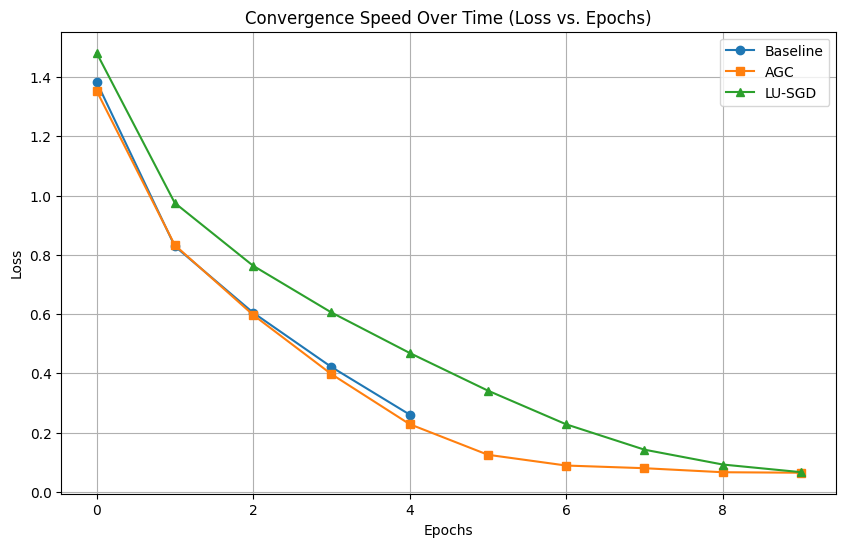

In [150]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(baseline_loss)), baseline_loss, label="Baseline", marker='o')
plt.plot(range(len(agc_loss)), agc_loss, label="AGC", marker='s')
plt.plot(range(len(lusgd_loss)), lusgd_loss, label="LU-SGD", marker='^')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Convergence Speed Over Time (Loss vs. Epochs)")
plt.legend()
plt.grid()
plt.show()

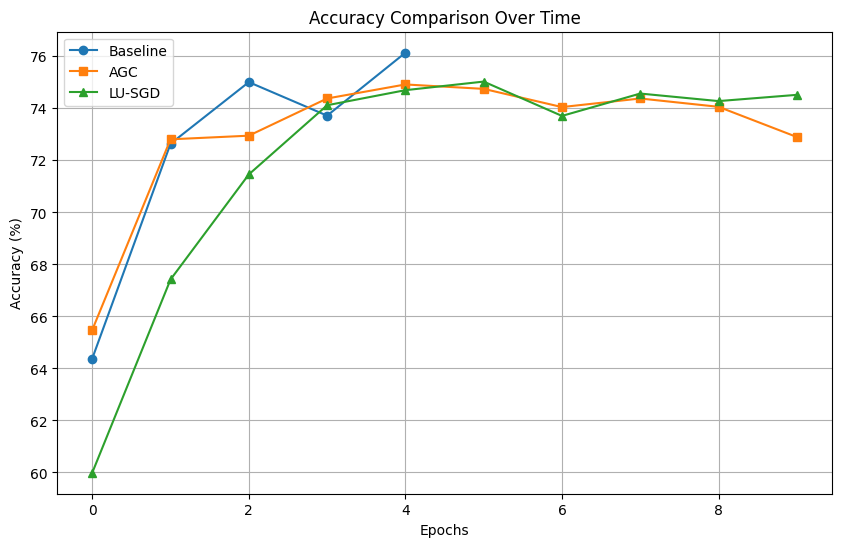

In [151]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(baseline_acc)), baseline_acc, label="Baseline", marker='o')
plt.plot(range(len(agc_acc)), agc_acc, label="AGC", marker='s')
plt.plot(range(len(lusgd_acc)), lusgd_acc, label="LU-SGD", marker='^')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison Over Time")
plt.legend()
plt.grid()
plt.show()

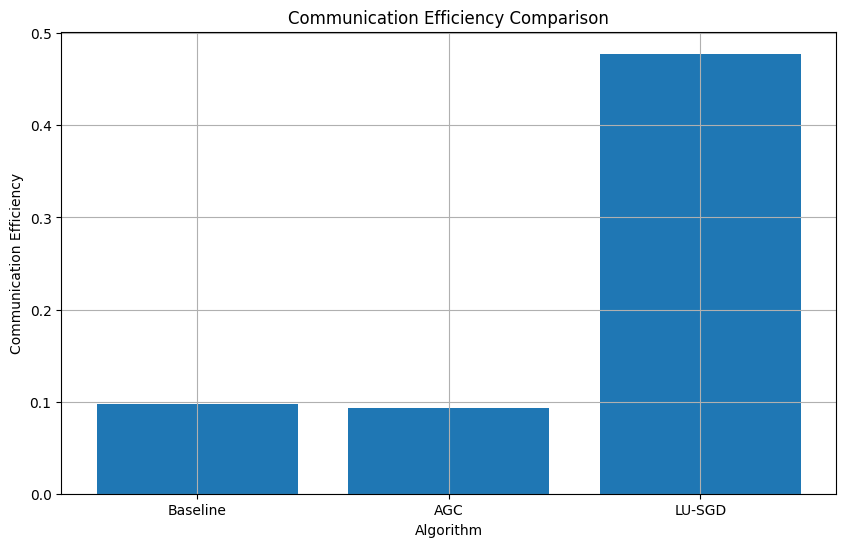

In [153]:
plt.figure(figsize=(10, 6))
plt.bar(["Baseline", "AGC", "LU-SGD"], [baseline_efficiency, agc_efficiency, lusgd_efficiency])
plt.xlabel("Algorithm")
plt.ylabel("Communication Efficiency")
plt.title("Communication Efficiency Comparison")
plt.grid()
plt.show()
